# Natural Language Processing

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

Modified by uramoon@kw.ac.kr

## Introduction

감성 분석 (Sentiment Analysis)은 자연어 처리 (Natural Language Processing, NLP)를 이용하여 텍스트의 감정을 파악하는 기술이다. 이 노트북에서는 영화 리뷰가 긍정적인지 부정적인지 분류할 것이다.

"This movie is not very good."을 보면 "very good"은 긍정적인 감정이지만 "not"이 있기 때문에 부정적인 감정으로 분류되어야 한다. 이러한 것을 어떻게 학습시킬 수 있을까?

1. 인공 신경망은 숫자를 입력으로 받아들이는데 텍스트를 어떻게 수치 데이터로 변환할지 생각해봐야 한다.
2. 문서의 길이는 문서마다 다른데 크기가 각기 다른 입력 데이터를 인공 신경망에 어떻게 입력해야할지 생각해봐야 한다. 

## Flowchart

1. Tokenizer를 이용하여 각 단어를 정수로 변환한다. 예) the: 1, and: 2, a: 3, ...
2. 임베딩 (embedding)을 통해 각 정수를 n차원 벡터로 변환한다. (가까운 단어는 가깝게 위치)
3. 문서를 순환 신경망 (recurrent neural network, RNN)에 입력하여 0 (부정적)부터 1 (긍적적) 사이의 실수를 출력하게 훈련한다.

The flowchart of the algorithm is roughly:

<img src="https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/20_natural_language_flowchart.png?raw=1" alt="Flowchart NLP" style="width: 300px;"/>

## Recurrent Neural Network (RNN)

RNN의 기본 유닛은 Recurrent Unit (RU)으로 LSTM (Long-Short-Term-Memory)과 성능 하락을 최소화하면서 LSTM을 단순화한 GRU (Gated Recurrent Unit)가 많이 사용된다.

RU는 과거의 상태를 기억하고 있다가 현재의 입력에 대해 자신의 상태를 바꾸면서 값을 출력한다.

새로운 상태는 과거의 상태와 현재의 입력에 따라 결정된다. 예를 들어 최근의 입력에 "not"이 있었고, 현재의 입력이 "good"이라면 새로운 상태는 "not good"에 해당하는 부정적인 감정을 기억할 것이다. 

![Recurrent unit](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/20_recurrent_unit.png?raw=1)

### Unrolled Network

RNN에서 RU가 다음 입력에 과거의 정보를 전달하는 과정을 다음과 같이 펼쳐서 도식화할 수 있다. 

RU의 메모리는 0으로 초기화된다.

가장 처음 "this"가 입력되면 메모리는 새로운 상태를 저장하고 무언가를 출력하지만 출력값을 사용하지는 않는다. 글을 끝까지 읽었을 때의 출력값만 활용할 것이다.

두 번째 단어는 "is"인데 바로 전에 읽은 "this"와 결합하여 새로운 상태를 저장한다.

세 번째 단어는 "not"인데 "not"을 기억하고 있다가 나중에 "good"을 읽었을 때 그것을 부정적인 단어로 바꿔주는 역할을 할 것이다. 

문서의 마지막 단어를 읽었을 때 0부터 1사이의 값을 출력하는데 이를 활용하여 감성 분석을 수행한다.

Note that for the sake of clarity, this figure doesn't show the mapping from text-words to integer-tokens and embedding-vectors, as well as the fully-connected Sigmoid layer on the output.

![Unrolled network](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/20_unrolled_flowchart.png?raw=1)

### Exploding & Vanishing Gradients

매 스텝 새로운 단어가 들어올 때마다 내부 상태를 변경할 경우 기울기 소실 혹은 폭주 문제가 발생할 수 있습니다.

하나의 텍스트가 500개의 단어로 구성된다고 했을 때 내부 상태가 500번 변화하게 되는데 각 변화마다 기울기를 곱할 때 기울기가 1 미만이면 그 값이 0에 가까워지고, 기울기가 1보다 크면 그 값은 매우 커집니다.

이러한 기울기 소실 / 폭주 문제를 해결하기 위해 매 입력마다 상태가 변화하지 않는 능력을 지닌 장기기억 메모리를 도입한 것이 LSTM과 GRU입니다.

## 준비 단계
1. 런타임을 GPU로 설정해주세요.
2. imdb.py와 download.py 파일을 Colab 환경에 복사해주세요.

## Imports

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from scipy.spatial.distance import cdist

We need to import several things from Keras.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Load Data

IMDB에서 50,000개의 영화 리뷰를 다운받습니다. Keras에 정제된 IMDB 데이터셋이 있지만 단어를 정수로 변환하는 작업을 직접 수행하기 위해 정제되지 않은 데이터셋을 사용합니다. 50,000개 중 25,000개는 훈련 데이터, 나머지 25,000개는 테스트 데이터입니다.



In [ ]:
import imdb

Automatically download and extract the files.

In [ ]:
imdb.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


## 다운받은 파일 확인
폴더를 새로고침하면 다운로드 받은 data 폴더가 보입니다.

1. 훈련 데이터 폴더: data/IMDB/aclImdb/train/ 
2. 테스트 데이터 폴더: data/IMDB/aclImdb/test/ 

In [ ]:
# 훈련 데이터의 pos 폴더에서 10점짜리 긍정적 리뷰 확인
#  This movie gets better each time I see it (which is quite often).
!cat data/IMDB/aclImdb/train/pos/10001_10.txt

Brilliant over-acting by Lesley Ann Warren. Best dramatic hobo lady I have ever seen, and love scenes in clothes warehouse are second to none. The corn on face is a classic, as good as anything in Blazing Saddles. The take on lawyers is also superb. After being accused of being a turncoat, selling out his boss, and being dishonest the lawyer of Pepto Bolt shrugs indifferently "I'm a lawyer" he says. Three funny words. Jeffrey Tambor, a favorite from the later Larry Sanders show, is fantastic here too as a mad millionaire who wants to crush the ghetto. His character is more malevolent than usual. The hospital scene, and the scene where the homeless invade a demolition site, are all-time classics. Look for the legs scene and the two big diggers fighting (one bleeds). This movie gets better each time I see it (which is quite often).

In [ ]:
# 훈련 데이터의 neg 폴더에서 1점짜리 부정적 리뷰 확인 
# this story is too painful to watch. 
!cat data/IMDB/aclImdb/train/neg/10002_1.txt

Sorry everyone,,, I know this is supposed to be an "art" film,, but wow, they should have handed out guns at the screening so people could blow their brains out and not watch. Although the scene design and photographic direction was excellent, this story is too painful to watch. The absence of a sound track was brutal. The loooonnnnng shots were too long. How long can you watch two people just sitting there and talking? Especially when the dialogue is two people complaining. I really had a hard time just getting through this film. The performances were excellent, but how much of that dark, sombre, uninspired, stuff can you take? The only thing i liked was Maureen Stapleton and her red dress and dancing scene. Otherwise this was a ripoff of Bergman. And i'm no fan f his either. I think anyone who says they enjoyed 1 1/2 hours of this is,, well, lying.

## 훈련 데이터와 테스트 데이터 만들기
x 값에는 리뷰 내용이 (텍스트), y 값에는 0 (부정) 혹은 1 (긍정)이 기록됩니다.


In [ ]:
x_train_text, y_train = imdb.load_data(train=True)
x_test_text, y_test = imdb.load_data(train=False)

# Convert to numpy arrays.
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
print("Train-set size: ", len(x_train_text))
print("Test-set size:  ", len(x_test_text))

np.array(x_train_text).shape, y_train.shape, np.array(x_test_text).shape, y_test.shape

Train-set size:  25000
Test-set size:   25000


((25000,), (25000,), (25000,), (25000,))

In [ ]:
# TODO: 훈련데이터의 0번째 x값(리뷰)과 y값(정답)을 출력해보세요.

print(x_train_text[0])
print(y_train[0])

This was the first "Walking Tall" movie I saw, I think in a $2 movie theater along Hollywood Blvd. , so I didn't have any reference to the first installment done by Joe Don Baker. I remember being shocked at the corrupted system of McNairy County and the brutality of the "redneck gangs". I was also amazed at the fact that one man decided he's not going to let it slide, and went out to do something about it. Courageous ? I thought so - to a point where it sent shivers up my spine.<br /><br />I think this movie is a great story about American courage to stand up and do something about a system that's only serving its own interest. I was pretty blown away about it, and think this is still one of the best movie of the hero/anti-hero genre, which one might laugh but includes recent movies like the "The Punisher", but even more so because it's a true story. The recent remake starring the "Rock" just doesn't do any justice to the real fire in the story of Buford Pusser.<br /><br />A "classic"

## Tokenizer

인공신경망은 숫자를 입력받기 때문에 우선 각 단어를 tokenizer를 통해 정수로 변환합니다.<br>Tokenizer는 데이터셋에서 가장 많이 등장하는 n개의 단어를 정수로 변환합니다.<br> 예) the: 1, and: 2, a: 3, ... 
<br>
일단 10000개의 단어만 사용하여 모델을 만들어봅시다.

In [ ]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)

type(tokenizer)

keras.preprocessing.text.Tokenizer

훈련 데이터와 테스트 데이터에 들어 있는 모든 단어를 변환할 필요가 있기 때문에 훈련 데이터와 테스트 데이터를 함께 tokenizer에 입력합니다.

In [ ]:
%%time
data_text = x_train_text + x_test_text
tokenizer.fit_on_texts(data_text)

CPU times: user 9.28 s, sys: 69.4 ms, total: 9.35 s
Wall time: 9.42 s


Tokenizer가 찾아낸 많이 등장하는 단어들입니다. 해당 단어들은 정수로 변환되고 나머지 단어들은 제거될 것입니다.

In [ ]:
tokenizer.word_index

{'the': 1,
 'and': 2,
 'a': 3,
 'of': 4,
 'to': 5,
 'is': 6,
 'br': 7,
 'in': 8,
 'it': 9,
 'i': 10,
 'this': 11,
 'that': 12,
 'was': 13,
 'as': 14,
 'for': 15,
 'with': 16,
 'movie': 17,
 'but': 18,
 'film': 19,
 'on': 20,
 'not': 21,
 'you': 22,
 'are': 23,
 'his': 24,
 'have': 25,
 'be': 26,
 'one': 27,
 'he': 28,
 'all': 29,
 'at': 30,
 'by': 31,
 'an': 32,
 'they': 33,
 'so': 34,
 'who': 35,
 'from': 36,
 'like': 37,
 'or': 38,
 'just': 39,
 'her': 40,
 'out': 41,
 'about': 42,
 'if': 43,
 "it's": 44,
 'has': 45,
 'there': 46,
 'some': 47,
 'what': 48,
 'good': 49,
 'when': 50,
 'more': 51,
 'very': 52,
 'up': 53,
 'no': 54,
 'time': 55,
 'my': 56,
 'even': 57,
 'would': 58,
 'she': 59,
 'which': 60,
 'only': 61,
 'really': 62,
 'see': 63,
 'story': 64,
 'their': 65,
 'had': 66,
 'can': 67,
 'me': 68,
 'well': 69,
 'were': 70,
 'than': 71,
 'much': 72,
 'we': 73,
 'bad': 74,
 'been': 75,
 'get': 76,
 'do': 77,
 'great': 78,
 'other': 79,
 'will': 80,
 'also': 81,
 'into': 82,
 'p

Tokenizer로 훈련 데이터의 텍스트를 정수로 변환합니다.

In [ ]:
x_train_tokens = tokenizer.texts_to_sequences(x_train_text)

type(x_train_tokens)

list

For example, here is a text from the training-set:

In [ ]:
# TODO: 훈련 데이터의 0번째 텍스트만 출력해보기
x_train_text[0]

'This was the first "Walking Tall" movie I saw, I think in a $2 movie theater along Hollywood Blvd. , so I didn\'t have any reference to the first installment done by Joe Don Baker. I remember being shocked at the corrupted system of McNairy County and the brutality of the "redneck gangs". I was also amazed at the fact that one man decided he\'s not going to let it slide, and went out to do something about it. Courageous ? I thought so - to a point where it sent shivers up my spine.<br /><br />I think this movie is a great story about American courage to stand up and do something about a system that\'s only serving its own interest. I was pretty blown away about it, and think this is still one of the best movie of the hero/anti-hero genre, which one might laugh but includes recent movies like the "The Punisher", but even more so because it\'s a true story. The recent remake starring the "Rock" just doesn\'t do any justice to the real fire in the story of Buford Pusser.<br /><br />A "cl

This text corresponds to the following list of tokens:

In [ ]:
# TODO: 정수로 변환된 0번째 텍스트만 출력해보기
# the는 1로, and는 2로, a는 3으로, of는 4로 변환됐는지 살펴보세요.
np.array(x_train_tokens[0])

array([  11,   13,    1,   86, 1334, 3506,   17,   10,  210,   10,  101,
          8,    3,  230,   17,  769,  340,  369,   34,   10,  154,   25,
         99, 2865,    5,    1,   86, 3889,  221,   31,  990, 1595, 3941,
         10,  382,  109, 2239,   30,    1, 1562,    4, 5911,    2,    1,
       5398,    4,    1, 7241, 6856,   10,   13,   81, 2717,   30,    1,
        192,   12,   27,  128,  877,  237,   21,  166,    5,  379,    9,
       6951,    2,  414,   41,    5,   77,  137,   42,    9, 7833,   10,
        190,   34,    5,    3,  220,  117,    9, 1428,   53,   56, 6340,
          7,    7,   10,  101,   11,   17,    6,    3,   78,   64,   42,
        283, 3102,    5,  778,   53,    2,   77,  137,   42,    3, 1562,
        196,   61, 4737,   92,  199,  616,   10,   13,  180, 2567,  243,
         42,    9,    2,  101,   11,    6,  130,   27,    4,    1,  116,
         17,    4,    1,  620, 1096,  620,  518,   60,   27,  233,  423,
         18, 1763, 1169,   97,   37,    1,    1,   

We also need to convert the texts in the test-set to tokens.

In [ ]:
# TODO: tokenizer로 테스트 데이터의 텍스트를 정수로 변환해보세요.
x_test_tokens = tokenizer.texts_to_sequences(x_test_text)

## Padding and Truncating Data

순환신경망은 임의의 길이를 지닌 입력을 처리할 수 있지만 훈련의 속도를 높이기 위해 동일 길이를 지닌 입력 데이터의 묶음 (batch) 단위로 훈련이 이루어지는 관계로 편의상 모든 입력 데이터의 길이를 동일하게 합니다. 모든 입력 데이터의 길이를 동일하게 하는 방법은 크게 두 가지가 있습니다.

1. 가장 길이가 긴 리뷰의 길이에 맞추어 다른 리뷰들의 앞, 혹은 뒤에 공백을 삽입한다.

2. 적당한 길이를 정한다음 길이가 긴 리뷰는 앞, 혹은 뒤를 잘라내고 짧은 리뷰는 앞, 혹은 뒤에 공백을 삽입한다.

첫 번째 방법은 지나치게 긴 리뷰가 있을 경우 다른 리뷰들에 지나치게 많은 공백이 들어가 데이터셋이 커져 훈련하는데 오래 걸리고 메모리의 낭비도 심해지는 단점이 있어 우리는 두 번째 방법을 사용합니다.

In [ ]:
# 각 리뷰에 단어 (토큰)가 몇 개씩 들어있는지 세어봅시다.

num_tokens = [] # 빈 리스트 생성

assert (len(x_train_tokens) == 25000) and (len(x_test_tokens) == 25000), "Check number of dataset"


# TODO: num_tokens에 각 리뷰의 단어 숫자를 저장하세요.
# num_tokens 원소는 50,000개이며 처음 25,000은 훈련 데이터의 단어숫자가 저장되어 있고,
# 나머지 25,000은 테스트 데이터의 단어숫자가 저장되어 있습니다.
# Hint: x_train_tokens[0]은 첫 번째 훈련 데이터의 단어들이 저장되어 있습니다. 그 길이는 len 함수로 알 수 있습니다.
for i in range(25000):
    num_tokens.append(len(x_train_tokens[i]))
    num_tokens.append(len(x_test_tokens[i]))


In [ ]:
# TODO: num_tokens 리스트를 num_tokens NumPy 배열로 변환하세요.
num_tokens = np.array(num_tokens)

The average number of tokens in a sequence is:

In [ ]:
# 모든 리뷰에서 사용한 평균 단어의 수는 다음과 같습니다.
np.mean(num_tokens)

221.27716

The maximum number of tokens in a sequence is:

In [ ]:
# TODO: 가장 긴 리뷰의 단어수를 출력해보세요.
# Hint: np.max
np.max(num_tokens)

2209

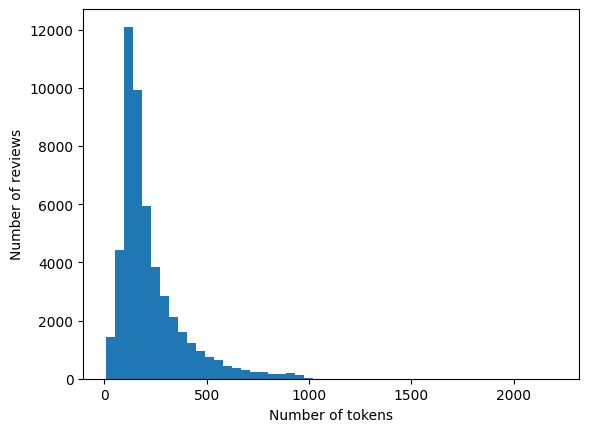

In [ ]:
# 리뷰에 사용된 단어수(토큰수)에 따른 리뷰의 수 살펴보기
# 대부분의 리뷰가 500개 이하의 토큰만 사용했음을 알 수 있음
plt.hist(num_tokens, bins=50)
plt.xlabel('Number of tokens')
plt.ylabel('Number of reviews')
plt.show()

The max number of tokens we will allow is set to the average plus 2 standard deviations.

In [ ]:
# TODO: num_tokens에서 평균 + 2 * 표준편차를 구하여 우리가 허용할 최대 단어의 개수인 max_tokens를 설정해보세요.
# num_tokens가 정규분포를 따른다면 97% 이상이 max_tokens보다 적은 단어만을 사용할 것입니다.
# Hint: np.mean과 np.std 사용

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

544

This covers about 95% of the data-set.

In [ ]:
# max_tokens보다 짧은 리뷰의 비율을 출력하는 코드
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.94532

리뷰의 94% 이상은 max_tokens보다 짧으므로 공백을 삽입하여 길이를 max_tokens로 맞춰주고, max_tokens보다 긴 리뷰의 길이는 max_tokens로 자를 필요가 있습니다. 모든 리뷰를 가장 길었던 리뷰의 길이로 맞췄다면 데이터셋 크기가 굉장히 커졌을 것입니다.<br>

공백을 삽입할 때 리뷰의 앞에 ('pre') 삽입할 수도 있고 마지막 ('post')에 삽입할 수도 있는데 인공신경망에 혼란을 주지 않기 위해 일관된 방식으로 삽입해야 합니다. (자르기도 동일)

In [ ]:
# 공백을 리뷰의 앞에 삽입
pad = 'pre'

In [ ]:
# 훈련 데이터의 길이를 max_tokens로 맞춰주기
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,  # 입력의 최대 길이는 max_tokens
                            padding=pad, truncating=pad)        # 패딩과 자르기 모두 리뷰의 앞부분에서 수행

In [ ]:
# TODO: 테스트 데이터의 길이를 max_tokens로 맞춰주세요.
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,  # 입력의 최대 길이는 max_tokens
                            padding=pad, truncating=pad)        # 패딩과 자르기 모두 리뷰의 앞부분에서 수행

We have now transformed the training-set into one big matrix of integers (tokens) with this shape:

In [ ]:
# 훈련 데이터: (리뷰 개수, 각 리뷰의 길이)
x_train_pad.shape

(25000, 544)

The matrix for the test-set has the same shape:

In [ ]:
# 테스트 데이터: (리뷰 개수, 각 리뷰의 길이)
x_test_pad.shape

(25000, 544)

For example, we had the following sequence of tokens above:

In [ ]:
# 패딩 전의 0번째 훈련 데이터 
np.array(x_train_tokens[0])

array([  11,   13,    1,   86, 1334, 3506,   17,   10,  210,   10,  101,
          8,    3,  230,   17,  769,  340,  369,   34,   10,  154,   25,
         99, 2865,    5,    1,   86, 3889,  221,   31,  990, 1595, 3941,
         10,  382,  109, 2239,   30,    1, 1562,    4, 5911,    2,    1,
       5398,    4,    1, 7241, 6856,   10,   13,   81, 2717,   30,    1,
        192,   12,   27,  128,  877,  237,   21,  166,    5,  379,    9,
       6951,    2,  414,   41,    5,   77,  137,   42,    9, 7833,   10,
        190,   34,    5,    3,  220,  117,    9, 1428,   53,   56, 6340,
          7,    7,   10,  101,   11,   17,    6,    3,   78,   64,   42,
        283, 3102,    5,  778,   53,    2,   77,  137,   42,    3, 1562,
        196,   61, 4737,   92,  199,  616,   10,   13,  180, 2567,  243,
         42,    9,    2,  101,   11,    6,  130,   27,    4,    1,  116,
         17,    4,    1,  620, 1096,  620,  518,   60,   27,  233,  423,
         18, 1763, 1169,   97,   37,    1,    1,   

This has simply been padded to create the following sequence. Note that when this is input to the Recurrent Neural Network, then it first inputs a lot of zeros. If we had padded 'post' then it would input the integer-tokens first and then a lot of zeros. This may confuse the Recurrent Neural Network.

In [ ]:
# TODO: 패딩 후의 0번째 훈련 데이터를 출력해보세요.
np.array(x_train_pad[0])

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

## Tokenizer Inverse Map

정수의 배열을 다시 텍스트로 바꿔주는 함수를 만들어봅시다.

In [ ]:
idx = tokenizer.word_index # tokenizer는 단어 (key)-> 정수 (value)이므로 
inverse_map = dict(zip(idx.values(), idx.keys())) # 정수 (value) -> 단어 (key)로 보내면 됩니다.

Helper-function for converting a list of tokens back to a string of words.

In [ ]:
# tokens_to_string 함수에 정수 배열을 입력하면 텍스트로 출력됩니다.
def tokens_to_string(tokens):
    # Map from tokens back to words.
    words = [inverse_map[token] for token in tokens if token != 0]
    
    # Concatenate all words.
    text = " ".join(words)

    return text

For example, this is the original text from the data-set:

In [ ]:
# 훈련 데이터의 0번째 리뷰 실제 텍스트
x_train_text[0]

'This was the first "Walking Tall" movie I saw, I think in a $2 movie theater along Hollywood Blvd. , so I didn\'t have any reference to the first installment done by Joe Don Baker. I remember being shocked at the corrupted system of McNairy County and the brutality of the "redneck gangs". I was also amazed at the fact that one man decided he\'s not going to let it slide, and went out to do something about it. Courageous ? I thought so - to a point where it sent shivers up my spine.<br /><br />I think this movie is a great story about American courage to stand up and do something about a system that\'s only serving its own interest. I was pretty blown away about it, and think this is still one of the best movie of the hero/anti-hero genre, which one might laugh but includes recent movies like the "The Punisher", but even more so because it\'s a true story. The recent remake starring the "Rock" just doesn\'t do any justice to the real fire in the story of Buford Pusser.<br /><br />A "cl

In [ ]:
# 정수로 변환된 훈련 데이터의 0번째 리뷰
np.array(x_train_tokens[0])

array([  11,   13,    1,   86, 1334, 3506,   17,   10,  210,   10,  101,
          8,    3,  230,   17,  769,  340,  369,   34,   10,  154,   25,
         99, 2865,    5,    1,   86, 3889,  221,   31,  990, 1595, 3941,
         10,  382,  109, 2239,   30,    1, 1562,    4, 5911,    2,    1,
       5398,    4,    1, 7241, 6856,   10,   13,   81, 2717,   30,    1,
        192,   12,   27,  128,  877,  237,   21,  166,    5,  379,    9,
       6951,    2,  414,   41,    5,   77,  137,   42,    9, 7833,   10,
        190,   34,    5,    3,  220,  117,    9, 1428,   53,   56, 6340,
          7,    7,   10,  101,   11,   17,    6,    3,   78,   64,   42,
        283, 3102,    5,  778,   53,    2,   77,  137,   42,    3, 1562,
        196,   61, 4737,   92,  199,  616,   10,   13,  180, 2567,  243,
         42,    9,    2,  101,   11,    6,  130,   27,    4,    1,  116,
         17,    4,    1,  620, 1096,  620,  518,   60,   27,  233,  423,
         18, 1763, 1169,   97,   37,    1,    1,   

We can recreate this text except for punctuation and other symbols, by converting the list of tokens back to words:

In [ ]:
# TODO: 정수 형태의 0번째 리뷰를 다시 단어로 변환해보세요.
# 모두 소문자로 변경되고, 잘 쓰이지 않는 단어들은 삭제된 상태입니다.
# Hint: 위에서 정의한 tokens_to_string 함수 이용
tokens_to_string(x_train_tokens[0])

"this was the first walking tall movie i saw i think in a 2 movie theater along hollywood so i didn't have any reference to the first installment done by joe don baker i remember being shocked at the system of county and the brutality of the redneck gangs i was also amazed at the fact that one man decided he's not going to let it slide and went out to do something about it courageous i thought so to a point where it sent up my spine br br i think this movie is a great story about american courage to stand up and do something about a system that's only serving its own interest i was pretty blown away about it and think this is still one of the best movie of the hero anti hero genre which one might laugh but includes recent movies like the the but even more so because it's a true story the recent remake starring the rock just doesn't do any justice to the real fire in the story of br br a classic that i'm sure will again in the future"

## Create the Recurrent Neural Network

We are now ready to create the Recurrent Neural Network (RNN). We will use the Keras API for this because of its simplicity. See Tutorial #03-C for a tutorial on Keras.

In [ ]:
model = Sequential()

자연어 처리를 위한 순환 신경망의 가장 첫 번째 층은 임베딩층입니다. 우리가 선택한 10000개의 단어를 우리가 지정한 차원에 보내 비슷한 단어가 가까운 곳에 위치하도록 만들 것입니다. (Tokenizer가 만든 정수는 1: the, 2: and, 3: a, 4: of과 같이 뜻이 비슷하지도 않은데 단어들이 가까운 곳에 위치해 있습니다.)

일반적으로 임베딩 차원은 100에서 300 정도를 사용하는데 일단 8차원만 사용해봅시다. 

In [ ]:
embedding_size = 8

The embedding-layer also needs to know the number of words in the vocabulary (`num_words`) and the length of the padded token-sequences (`max_tokens`). We also give this layer a name because we need to retrieve its weights further below.

In [ ]:
# 임베딩층 추가
model.add(Embedding(input_dim=num_words,      # 사용하는 단어의 개수
                    output_dim=embedding_size,# 임베딩 차원
                    input_length=max_tokens,  # 리뷰의 길이
                    name='layer_embedding'))

순환 유닛인 GRU를 추가하고 Dense로 묶어 하나의 출력에서 0과 1사이의 실수를 출력하도록 합니다.

In [ ]:
model.add(GRU(units=256))
model.add(Dense(1, activation='sigmoid')) # 이전 층의 입력을 받아들여 0부터 1사이의 실수값 하나 출력 (sigmoid)

Use the Adam optimizer with the given learning-rate.

In [ ]:
optimizer = Adam(learning_rate=1e-3)

Compile the Keras model so it is ready for training.

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_embedding (Embedding)  (None, 544, 8)           80000     
                                                                 
 gru (GRU)                   (None, 256)               204288    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 284,545
Trainable params: 284,545
Non-trainable params: 0
_________________________________________________________________


## Train the Recurrent Neural Network

We can now train the model. Note that we are using the data-set with the padded sequences. We use 5% of the training-set as a small validation-set, so we have a rough idea whether the model is generalizing well or if it is perhaps over-fitting to the training-set.

In [ ]:
# validation을 통해 테스트셋에서의 성능을 가늠할 수 있습니다.
# 훈련데이터에 대한 성능은 개선되는데 validation에서 악화된다면 과적합이 일어나는 것일 수도 있습니다.
from keras.callbacks import EarlyStopping

# TODO: 자유롭게 설정, restore_best_weights=True 추천
es = EarlyStopping()

model.fit(x_train_pad, y_train, callbacks=es,
          validation_split=0.2, epochs=10000, batch_size=64)

Epoch 1/10000
313/313 [==============================] - 73s 205ms/step - loss: 0.5486 - accuracy: 0.7254 - val_loss: 0.8771 - val_accuracy: 0.6042
Epoch 2/10000
313/313 [==============================] - 42s 136ms/step - loss: 0.3160 - accuracy: 0.8729 - val_loss: 0.4313 - val_accuracy: 0.8032
Epoch 3/10000
313/313 [==============================] - 28s 89ms/step - loss: 0.2642 - accuracy: 0.8970 - val_loss: 0.4186 - val_accuracy: 0.8354
Epoch 4/10000
313/313 [==============================] - 24s 78ms/step - loss: 0.1946 - accuracy: 0.9277 - val_loss: 0.6248 - val_accuracy: 0.7552


## Performance on Test-Set

Now that the model has been trained we can calculate its classification accuracy on the test-set.

In [ ]:
# 테스트셋에서의 성능 평가
%%time
result = model.evaluate(x_test_pad, y_test)

782/782 [==============================] - 9s 11ms/step - loss: 0.4101 - accuracy: 0.8398
CPU times: user 6.98 s, sys: 352 ms, total: 7.33 s
Wall time: 9.11 s


In [ ]:
print("Accuracy: {0:.2%}".format(result[1]))

Accuracy: 83.98%


## New Data

Let us try and classify new texts that we make up. Some of these are obvious, while others use negation and sarcasm to try and confuse the model into mis-classifying the text.

In [ ]:
# 새로운 데이터셋 8개 생성하여 texts에 저장
text1 = "This movie is fantastic! I really like it because it is so good!"
text2 = "Good movie!"
text3 = "Maybe I like this movie."
text4 = "Meh ..."
text5 = "If I were a drunk teenager then this movie might be good."
text6 = "Bad movie!"
text7 = "Not a good movie!"
text8 = "This movie really sucks! Can I get my money back please?"
texts = [text1, text2, text3, text4, text5, text6, text7, text8]

We first convert these texts to arrays of integer-tokens because that is needed by the model.

In [ ]:
# TODO: tokenizer로 texts를 정수로 변환하세요.
tokens = tokenizer.texts_to_sequences(texts)

To input texts with different lengths into the model, we also need to pad and truncate them.

In [ ]:
# TODO: 패딩으로 tokens의 길이를 맞춰주세요.
tokens_pad = pad_sequences(tokens, maxlen=max_tokens,  # 입력의 최대 길이는 max_tokens
                            padding=pad, truncating=pad)        # 패딩과 자르기 모두 리뷰의 앞부분에서 수행

tokens_pad.shape

(8, 544)

We can now use the trained model to predict the sentiment for these texts.

In [ ]:
# TODO: model로 tokens_pad를 예측해보세요.
# 1에 가까울 수록 긍정적이고 0에 가까울 수록 부정적입니다.
# 잘 예측했나요? 운에 따라 결과가 다를 수 있습니다.
model.predict(tokens_pad)

1/1 [==============================] - 0s 475ms/step


array([[0.9860665 ],
       [0.96744543],
       [0.89856744],
       [0.95357597],
       [0.8383949 ],
       [0.74630123],
       [0.955057  ],
       [0.29703137]], dtype=float32)

A value close to 0.0 means a negative sentiment and a value close to 1.0 means a positive sentiment. These numbers will vary every time you train the model.

## Newer Data
우리 모델은 평균 200개 이상의 단어가 쓰인 리뷰로 학습됐습니다. 위와 같이 매우 짧은 리뷰에 대해서는 잘 동작하지 않을 수도 있으니 <br>IMDb에서 가디언즈 오브 갤럭시 3의 10점짜리 리뷰와 5점 이하의 리뷰로 테스트 해봅시다.<br>
https://www.imdb.com/title/tt6791350/reviews?ref_=tt_urv

In [ ]:
# text1 = #TODO: 10점짜리 리뷰, 제목 제외 본문만 붙여넣으세요.
# text2 = #TODO: 10점짜리 리뷰, 제목 제외 본문만 붙여넣으세요.
# text3 = #TODO: 5점 이하 리뷰, 제목 제외 본문만 붙여넣으세요.
# text4 = #TODO: 5점 이하 리뷰, 제목 제외 본문만 붙여넣으세요.
# texts = [text1, text2, text3, text4]

text1 = "It all leads back to where we once started off as all great trilogies have indicated from the past. But GOTG surpasses expectations with what is nothing short of phenomenal performances by the cast and truly well written and does not shy away from what could only be understood from what requires a sense of maturity to understand. Rockets back story alone is on occasion dark and incredibly sad it had me in tears at a few instances during the film. Honestly I did not expect this, James Gunn yet again provides an absolutely beautiful piece of cinematography and I have to say I really hope in the future they dive back into the story of the colony . With Adam warlock finally in the MCU it's most likely there will be some cameos. But it does deliver in the traditional guardians humor but this film is meant about more for the mature audience of marvel. Trust me this is a great film."
text2 = "I'm not one to cry at movies often, but this one broke me. Four is merely an estimate. I spent the entire last hour of the film in and out of tears. Guardians of the Galaxy Vol. 3 is an unexpected masterpiece, and a work of art that absolutely broke me. From the soundtrack, to the writing, to the characters, to the use of flashbacks, this movie is about as close to perfection as it gets. Having already established all of the characters, it managed to be heart-wrenching all the way through. This movie leaves a bittersweet taste in your mouth, and with so much to think about. It manages to make 2 and 1/2 hours feel ten times as short. I never expected to fall in love with this movie, but it got to me in such a visceral way that I'll never forget the experience of seeing it."
text3 = "Depressing, dark, with lame humour sprinkled in with ill fitting music jammed in at random. I can't recognize anything 'marvel' about this. The tone, weak writing and CGI jammed down your throat all seems more like an audition to work for DC and their low quality entertainment, rather than any serious attempt to grow the Guardian's franchise. Gunn could have, and should have shaved 60 minutes from this 2 hour grim mess. I've no interest in seeing any further Gunn projects, especially if he continues making animal snuff films under a Marvel banner. This isn't a family movie, it's for people who think torture can be entertaining. No thanks, Marvel."
text4 = "Y'all must have watched a different movie than me. This is the worst Marvel in the last ten years in my opinion. Little to no plot/story, dumb villains, bad costumes, cheesy lines, unholy amount of plotholes, pure CGI feast... The only good thing in that movie was the cinematography, that's it. I questioned my status as a GotG fan and asked myself several times why I have to go through this 'movie'. Come on. Nothing made even slightly sense and the characters get weirder and worse. It just felt like a Disney movie the whole time but like a Disney movie where Walt Disney smoked crack and got blackout drunk before he wrote the script. It was even worse than Multiverse of Madness and Thor Love & Thunder and I thought thats's impossible. Just imagine the bad plot and nonsense from MoM combined withe cornyness and cringe of Love & Thunder and voilà that's GotG 3. It doesn't have the charm of the old GotG movies and the music was not that important anymore. Total waste of money and time."
texts = [text1, text2, text3, text4]

In [ ]:
#TODO: 상기 texts에 대해 예측해보세요.
#Hint: tokenizer와 padding을 이용해야 합니다.

tokens = tokenizer.texts_to_sequences(texts)
tokens_pad = pad_sequences(tokens, maxlen=max_tokens,  # 입력의 최대 길이는 max_tokens
                            padding=pad, truncating=pad)    # 패딩과 자르기 모두 리뷰의 앞부분에서 수행
tokens_pad.shape

(4, 544)

## Embeddings

임베딩을 통해 각 단어가 어떻게 변환되는지 살펴봅시다.

The model cannot work on integer-tokens directly, because they are integer values that may range between 0 and the number of words in our vocabulary, e.g. 10000. So we need to convert the integer-tokens into vectors of values that are roughly between -1.0 and 1.0 which can be used as input to a neural network.

This mapping from integer-tokens to real-valued vectors is also called an "embedding". It is essentially just a matrix where each row contains the vector-mapping of a single token. This means we can quickly lookup the mapping of each integer-token by simply using the token as an index into the matrix. The embeddings are learned along with the rest of the model during training.

Ideally the embedding would learn a mapping where words that are similar in meaning also have similar embedding-values. Let us investigate if that has happened here.

First we need to get the embedding-layer from the model:

In [ ]:
# 임베딩 층 불러오기
layer_embedding = model.get_layer('layer_embedding')

We can then get the weights used for the mapping done by the embedding-layer.

In [ ]:
# 임베딩 층의 가중치 불러오기
weights_embedding = layer_embedding.get_weights()[0]

Note that the weights are actually just a matrix with the number of words in the vocabulary times the vector length for each embedding. That's because it is basically just a lookup-matrix.

In [ ]:
# 10,000개의 단어를 8차원으로 보내고 있습니다.
weights_embedding.shape

(10000, 8)

Let us get the integer-token for the word 'good', which is just an index into the vocabulary.

In [ ]:
# tokenizer에서 good의 위치
token_good = tokenizer.word_index['good']
token_good

49

Let us also get the integer-token for the word 'great'.

In [ ]:
# tokenizer에서 great의 위치
token_great = tokenizer.word_index['great']
token_great

78

These integertokens may be far apart and will depend on the frequency of those words in the data-set.

Now let us compare the vector-embeddings for the words 'good' and 'great'. Several of these values are similar, although some values are quite different. Note that these values will change every time you train the model.

In [ ]:
# good의 임베딩 결과
weights_embedding[token_good]

array([ 0.02290636, -0.0483623 ,  0.06881162, -0.02499575,  0.03896544,
       -0.04431306, -0.08414181, -0.01412714], dtype=float32)

In [ ]:
# great의 임베딩 결과
weights_embedding[token_great]

array([ 0.09011584, -0.10850934,  0.07751409, -0.1187185 ,  0.14966343,
       -0.08176973, -0.16711865, -0.0904062 ], dtype=float32)

Similarly, we can compare the embeddings for the words 'bad' and 'horrible'.

In [ ]:
# tokenizer에서 bad와 horrible
token_bad = tokenizer.word_index['bad']
token_horrible = tokenizer.word_index['horrible']

In [ ]:
# TODO: bad의 임베딩 결과
weights_embedding[token_bad]

array([-0.09303937,  0.06197396, -0.06656532,  0.11336791, -0.12040412,
        0.05323533,  0.06468268,  0.11670924], dtype=float32)

In [ ]:
# TODO: horrible의 임베딩 결과
weights_embedding[token_horrible]

array([-0.10119378,  0.20147762, -0.17866418,  0.10875463, -0.12750065,
        0.18288188,  0.13107546,  0.13500582], dtype=float32)

임베딩 결과를 보면 good과 great은 비슷한 곳에 위치하고 good과 bad는 반대되는 곳에 위치한 것을 볼 수 있습니다.

### Sorted Words

코사인 유사도로 임베딩 공간에서 비슷한 단어를 찾아봅시다.


In [ ]:
# 주어진 단어와 비슷한 단어를 찾아주는 함수
def print_sorted_words(word, metric='cosine'):
    """
    Print the words in the vocabulary sorted according to their
    embedding-distance to the given word.
    Different metrics can be used, e.g. 'cosine' or 'euclidean'.
    """

    # Get the token (i.e. integer ID) for the given word.
    token = tokenizer.word_index[word]

    # Get the embedding for the given word. Note that the
    # embedding-weight-matrix is indexed by the word-tokens
    # which are integer IDs.
    embedding = weights_embedding[token]

    # Calculate the distance between the embeddings for
    # this word and all other words in the vocabulary.
    distances = cdist(weights_embedding, [embedding],
                      metric=metric).T[0]
    
    # Get an index sorted according to the embedding-distances.
    # These are the tokens (integer IDs) for words in the vocabulary.
    sorted_index = np.argsort(distances)
    
    # Sort the embedding-distances.
    sorted_distances = distances[sorted_index]
    
    # Sort all the words in the vocabulary according to their
    # embedding-distance. This is a bit excessive because we
    # will only print the top and bottom words.
    sorted_words = [inverse_map[token] for token in sorted_index
                    if token != 0]

    # Helper-function for printing words and embedding-distances.
    def _print_words(words, distances):
        for word, distance in zip(words, distances):
            print("{0:.3f} - {1}".format(distance, word))

    # Number of words to print from the top and bottom of the list.
    k = 10

    print("Distance from '{0}':".format(word))

    # Print the words with smallest embedding-distance.
    _print_words(sorted_words[0:k], sorted_distances[0:k])

    print("...")

    # Print the words with highest embedding-distance.
    _print_words(sorted_words[-k:], sorted_distances[-k:])

We can then print the words that are near and far from the word 'great' in terms of their vector-embeddings. Note that these may change each time you train the model.

In [ ]:
# great와 비슷한 단어 10개, 반대 단어 10개
print_sorted_words('great', metric='cosine')

Distance from 'great':
0.000 - great
0.007 - angelina
0.007 - hellraiser
0.009 - stitches
0.009 - beauty
0.010 - ranger
0.011 - blob
0.012 - louis
0.012 - neat
0.015 - eliminate
...
1.984 - dreck
1.985 - traps
1.985 - muddled
1.985 - wouldn't
1.986 - altman
1.986 - artsy
1.987 - heads
1.987 - trash
1.987 - unbearable
1.993 - reasonably


Similarly, we can print the words that are near and far from the word 'worst' in terms of their vector-embeddings.

In [ ]:
# TODO: worst와 비슷한 단어 10개, 반대 단어 10개
print_sorted_words('worst', metric='cosine')

Distance from 'worst':
0.000 - worst
0.005 - rene
0.005 - hercules
0.005 - pointless
0.006 - mst3k
0.006 - unappealing
0.007 - fetish
0.007 - madsen
0.008 - nanny
0.008 - muddled
...
1.993 - differently
1.994 - errol
1.994 - greene
1.994 - marvelously
1.995 - worlds
1.996 - friendships
1.996 - chavez
1.996 - captures
1.996 - eliminate
1.999 - ida


## Conclusion

감성 분석에서 순환 신경망은 비교적 만족스러운 성능을 보이지만 사람과는 전혀 다른 방식으로 감정을 계산해냅니다. 

## 연습문제 (수행할 필요 없습니다.)

수행할 때마다 다른 결과를 얻을 수 있습니다.

* 현재 Tokenizer가 가장 자주 쓰이는 10,000개의 단어를 처리하는데 5000개만 사용하면 성능이 어떻게 변할까요? 
* 임베딩을 8차원에서 수행하는데 200차원으로 늘리면 성능이 어떻게 변할까요?


## License (MIT)

Copyright (c) 2022 by uramoon@kw.ac.kr<br>
Copyright (c) 2018 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.